In [1]:
#Import libraries
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from itertools import combinations
from scipy.optimize import minimize
from scipy.stats import rankdata
from colorama import Fore, Style

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

gc.collect()

#Default size of plots
plt.rcParams ['figure.figsize'] = (8,6)

#Standardized output formatting
def print_section_header(title) :
    """Standardized section header printing"""
    print(f"\n{Fore.GREEN} {'='*20} {title.upper()} {'='*20} {Style.RESET_ALL}")
    
def print_step(message) :
    """Standardized step printing"""
    print(f" {message}")

def print_success(message) :
    """Standardized success printing"""
    print(f" {message}")



In [2]:
#Load data
print_section_header("Loading data")
print_step("Loading training, test, and external data")

train = pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv")

print_success(f"Training data loaded: {train.shape}")
print_success(f"Testing data loaded: {test.shape}")

TARGET = 'diagnosed_diabetes'
ID_COL = 'id'

#Combining the data so that there can be equal coloumns for feature engineering
test[TARGET] = -1 
combine = pd.concat([train, test], axis=0, ignore_index=True)
print_success(f"Combined data for processing: {combine.shape}")


 ==================== LOADING DATA ==================== 
 Loading training, test, and external data
 Training data loaded: (700000, 26)
 Testing data loaded: (300000, 25)
 Combined data for processing: (1000000, 26)


In [3]:
print_section_header("Data exploration")

#Data Dimensions
print_step("Checking data structure")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

#Data Head
print_step("First 5 rows of Training Data (All Variables):")
#This shows the actual values for all columns
display(train.head())

#Statistical Summary
print_step("Statistical summary (Training Data):")
display(train.describe().style.format("{:.2f}"))


 ==================== DATA EXPLORATION ==================== 
 Checking data structure
Train shape: (700000, 26)
Test shape: (300000, 26)
 First 5 rows of Training Data (All Variables):


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


 Statistical summary (Training Data):


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
count,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00,700000.00
mean,349999.50,50.36,2.07,80.23,5.96,7.00,6.01,25.87,0.86,116.29,75.44,70.17,186.82,53.82,102.91,123.08,0.15,0.18,0.03,0.62
std,202072.74,11.66,1.05,51.20,1.46,0.90,2.02,2.86,0.04,11.01,6.83,6.94,16.73,8.27,19.02,24.74,0.36,0.39,0.17,0.48
min,0.00,19.00,1.00,1.00,0.10,3.10,0.60,15.10,0.68,91.00,51.00,42.00,117.00,21.00,51.00,31.00,0.00,0.00,0.00,0.00
25%,174999.75,42.00,1.00,49.00,5.00,6.40,4.60,23.90,0.83,108.00,71.00,65.00,175.00,48.00,89.00,106.00,0.00,0.00,0.00,0.00
50%,349999.50,50.00,2.00,71.00,6.00,7.00,6.00,25.90,0.86,116.00,75.00,70.00,187.00,54.00,103.00,123.00,0.00,0.00,0.00,1.00
75%,524999.25,58.00,3.00,96.00,7.00,7.60,7.40,27.80,0.88,124.00,80.00,75.00,199.00,59.00,116.00,139.00,0.00,0.00,0.00,1.00
max,699999.00,89.00,9.00,747.00,9.90,9.90,16.50,38.40,1.05,163.00,104.00,101.00,289.00,90.00,205.00,290.00,1.00,1.00,1.00,1.00


 Analyzing Target Balance


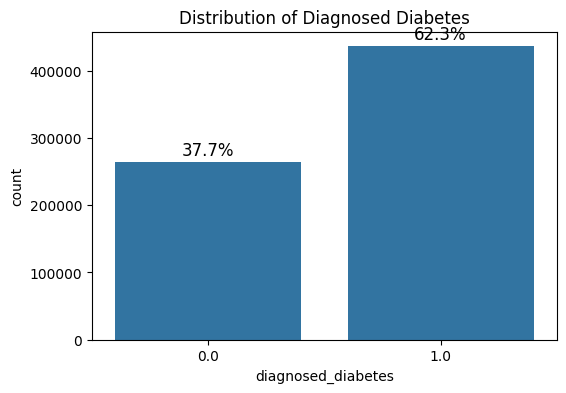

In [4]:
import warnings
warnings.filterwarnings("ignore")

print_step("Analyzing Target Balance")

#Create plot
plt.figure(figsize=(6, 4))

#Simple count plot
ax = sns.countplot(x=train[TARGET])

plt.title("Distribution of Diagnosed Diabetes")

#Add percentage labels
total = len(train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

 Calculating Feature Correlations


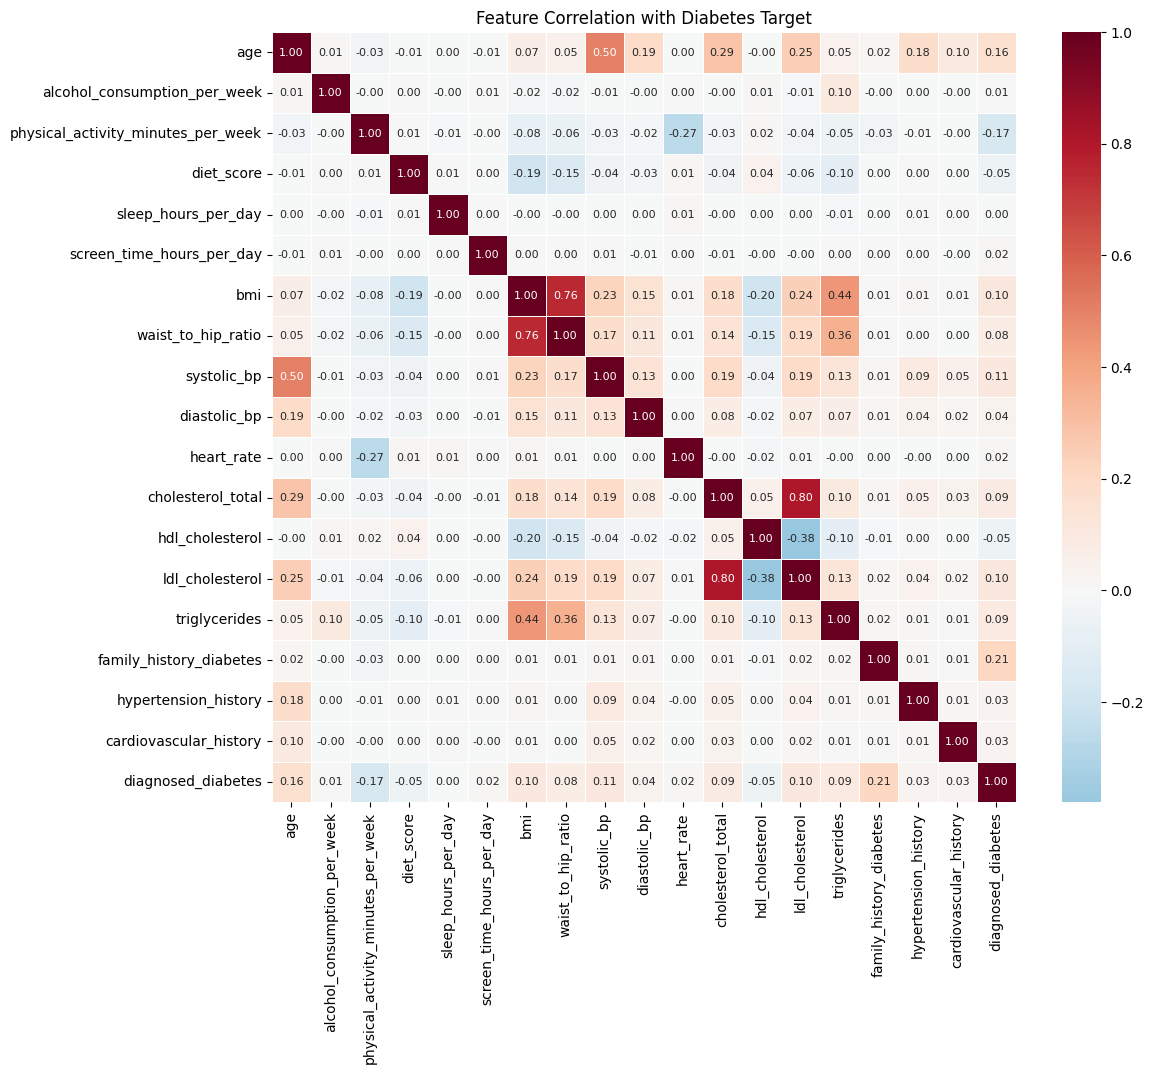

In [5]:
import warnings
warnings.filterwarnings("ignore")

print_step("Calculating Feature Correlations")

#Select only numeric columns (excluding ID and target)
numeric_cols = train.select_dtypes(include=np.number).columns
numeric_cols = numeric_cols.drop([ID_COL, TARGET])

#Columns to use for correlation
corr_cols = list(numeric_cols) + [TARGET]

#Plot correlation heatmap
plt.figure(figsize=(12, 10))

#Sample data to speed up computation
corr_matrix = train[corr_cols].sample(100000).corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5, annot_kws={"size": 8})

plt.title("Feature Correlation with Diabetes Target")
plt.show()

In [6]:
print_section_header("Feature engineering: Health features")
print_step("Creating health risk interaction features")

def create_features(df):
    #Copy to avoid modifying the original dataframe in place
    df = df.copy()
    #Body Metrics
    df['bmi_waist_ratio'] = df['bmi'] * df['waist_to_hip_ratio']
    #Lifestyle Ratios
    df['activity_to_screen_ratio'] = df['physical_activity_minutes_per_week'] / (df['screen_time_hours_per_day'] + 1)   
    #Cardiovascular Indicators
    df['bp_diff'] = df['systolic_bp'] - df['diastolic_bp']
    #Cholesterol Ratios
    df['cholesterol_ratio'] = df['cholesterol_total'] / (df['hdl_cholesterol'] + 0.1)
    return df

train = create_features(train)
test = create_features(test)

print_success(f"New features created. Total columns: {train.shape[1]}")


 ==================== FEATURE ENGINEERING: HEALTH FEATURES ==================== 
 Creating health risk interaction features
 New features created. Total columns: 30


In [7]:
print_section_header("Feature engineering: Targeted instructions")

#Define your top features based on previous importance plots
top_features = ['family_history_diabetes', 'physical_activity_minutes_per_week', 'age', 'triglycerides', 'bmi'] 

print_step(f"Creating pairwise interactions for: {', '.join(top_features)}")

#Generate and add the features to both train and test
for feat1, feat2 in combinations(top_features, 2):
    new_col_name = f"{feat1}_x_{feat2}"

    train[new_col_name] = train[feat1] * train[feat2]
    
    test[new_col_name] = test[feat1] * test[feat2]
    
    print(f"   + Created: {new_col_name}")

print_success(f"Added {len(list(combinations(top_features, 2)))} new interaction features.")


 ==================== FEATURE ENGINEERING: TARGETED INSTRUCTIONS ==================== 
 Creating pairwise interactions for: family_history_diabetes, physical_activity_minutes_per_week, age, triglycerides, bmi
   + Created: family_history_diabetes_x_physical_activity_minutes_per_week
   + Created: family_history_diabetes_x_age
   + Created: family_history_diabetes_x_triglycerides
   + Created: family_history_diabetes_x_bmi
   + Created: physical_activity_minutes_per_week_x_age
   + Created: physical_activity_minutes_per_week_x_triglycerides
   + Created: physical_activity_minutes_per_week_x_bmi
   + Created: age_x_triglycerides
   + Created: age_x_bmi
   + Created: triglycerides_x_bmi
 Added 10 new interaction features.


In [8]:
print_section_header("Preparing categorical features")
print_step("Converting object columns to categorical type")

# Identify categorical (object-type) columns
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# Remove ID and target columns if present
cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]

print(f"Found {len(cat_cols)} categorical columns:")
print(cat_cols)

# Convert categorical columns in both train and test datasets
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

print_success("Categorical conversion complete.")


 ==================== PREPARING CATEGORICAL FEATURES ==================== 
 Converting object columns to categorical type
Found 6 categorical columns:
['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
 Categorical conversion complete.


In [9]:
#Define models with tuned hyperparameters
models = {
    "XGBoost": XGBClassifier(
        n_estimators=2000,
        max_depth=7,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.6,
        eval_metric="logloss",
        early_stopping_rounds=50,
        tree_method="hist",
        enable_categorical=True,
        random_state=42
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=9,
        subsample=0.8,
        colsample_bytree=0.6,
        metric="auc",
        importance_type="gain",
        verbosity=-1,
        random_state=42
    ),

    "CatBoost": CatBoostClassifier(
        iterations=2000,
        learning_rate=0.03,
        depth=7,
        loss_function="Logloss",
        eval_metric="AUC",
        early_stopping_rounds=50,
        cat_features=cat_cols,
        verbose=False,
        allow_writing_files=False,
        random_state=42
    )
}

#Cross-validation setup
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

#Containers for predictions
oof_preds = pd.DataFrame(index=train.index)
test_preds = pd.DataFrame(index=test.index)

#Prepare feature matrix and target
features = [c for c in train.columns if c not in [ID_COL, TARGET]]
X = train[features]
y = train[TARGET]
X_test = test[features]

print_success(f"Framework ready for {len(features)} features.")

 Framework ready for 38 features.


In [10]:
print_section_header("Training")

for model_name, model in models.items():
    print_step(f"Starting {model_name} Cross-Validation...")

    oof = np.zeros(len(train))
    test_pred = np.zeros(len(test))
    fold_scores = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        # Fit model (library-specific logic)
        if model_name == "XGBoost":
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        elif model_name == "LightGBM":
            from lightgbm import early_stopping, log_evaluation
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                callbacks=[early_stopping(50), log_evaluation(0)]
            )

        else:  # CatBoost
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)

        # Predict probabilities
        val_preds = model.predict_proba(X_val)[:, 1]
        test_preds_fold = model.predict_proba(X_test)[:, 1]

        # Store predictions
        oof[val_idx] = val_preds
        test_pred += test_preds_fold / N_FOLDS

        # Evaluate fold
        auc = roc_auc_score(y_val, val_preds)
        fold_scores.append(auc)
        print(f"    Fold {fold + 1} ROC AUC: {auc:.5f}")

    oof_preds[model_name] = oof
    test_preds[model_name] = test_pred
    print_success(f"{model_name} CV Mean AUC: {np.mean(fold_scores):.5f}")

print_section_header("Individual model performance complete")


 ==================== TRAINING ==================== 
 Starting XGBoost Cross-Validation...
    Fold 1 ROC AUC: 0.72598
    Fold 2 ROC AUC: 0.72499
    Fold 3 ROC AUC: 0.72568
    Fold 4 ROC AUC: 0.72701
    Fold 5 ROC AUC: 0.72598
 XGBoost CV Mean AUC: 0.72593
 Starting LightGBM Cross-Validation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1358]	valid_0's auc: 0.727023
    Fold 1 ROC AUC: 0.72702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1315]	valid_0's auc: 0.725376
    Fold 2 ROC AUC: 0.72538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1341]	valid_0's auc: 0.726301
    Fold 3 ROC AUC: 0.72630
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[981]	valid_0's auc: 0.726791
    Fold 4 ROC AUC: 0.72679
Training until validation scores don't improve for 50 rounds
Early stopping, bes

In [11]:
print_step("Finding the optimal weights for each model")

#Model names used in blending
model_names = list(models.keys())

#Objective function to minimize=
def auc_loss(weights):
    weights = weights / np.sum(weights)  #normalize

    blended = np.zeros(len(train))
    for i, name in enumerate(model_names):
        blended += oof_preds[name] * weights[i]

    return -roc_auc_score(y, blended)

#Initial equal weights
initial_weights = [1 / len(model_names)] * len(model_names)

#Weights constrained between 0 and 1
bounds = [(0, 1)] * len(model_names)

#Optimize weights
result = minimize(auc_loss, initial_weights, bounds=bounds, method="SLSQP")
best_weights = result.x / np.sum(result.x)

#Create final blended predictions
oof_preds["Final_Blend"] = 0
test_preds["Final_Blend"] = 0

for i, name in enumerate(model_names):
    oof_preds["Final_Blend"] += oof_preds[name] * best_weights[i]
    test_preds["Final_Blend"] += test_preds[name] * best_weights[i]

#Display results
print_step("Optimized Weights Found:")
for name, w in zip(model_names, best_weights):
    print(f"   * {name}: {w:.4f}")

print_success(f"Blended OOF ROC AUC: {roc_auc_score(y, oof_preds['Final_Blend']):.5f}")

 Finding the optimal weights for each model
 Optimized Weights Found:
   * XGBoost: 0.3333
   * LightGBM: 0.3333
   * CatBoost: 0.3333
 Blended OOF ROC AUC: 0.72679


In [12]:
print_section_header("Post processing: Rank blending")
print_step("Converting probabilities to ranks to stabilize the ensemble")

model_names = list(models.keys())

oof_ranks = pd.DataFrame(index=train.index)
test_ranks = pd.DataFrame(index=test.index)

#Convert probabilities to normalized ranks
for name in model_names:
    oof_ranks[name] = rankdata(oof_preds[name]) / len(train)
    test_ranks[name] = rankdata(test_preds[name]) / len(test)

#Rank-based optimization objective
def rank_auc_loss(weights):
    weights = weights / np.sum(weights)
    blended = oof_ranks[model_names].values @ weights
    return -roc_auc_score(y, blended)

#Optimize rank weights
res_rank = minimize(rank_auc_loss, initial_weights, bounds=bounds, method="SLSQP")
best_rank_weights = res_rank.x / np.sum(res_rank.x)

#Final rank-blended predictions
oof_preds["Rank_Blend"] = oof_ranks[model_names].values @ best_rank_weights
test_preds["Rank_Blend"] = test_ranks[model_names].values @ best_rank_weights

print_step("Optimized Rank Weights Found:")
for name, w in zip(model_names, best_rank_weights):
    print(f"   * {name}: {w:.4f}")

print_success(f"Rank-Blended OOF ROC AUC: {roc_auc_score(y, oof_preds['Rank_Blend']):.5f}")


 ==================== POST PROCESSING: RANK BLENDING ==================== 
 Converting probabilities to ranks to stabilize the ensemble
 Optimized Rank Weights Found:
   * XGBoost: 0.3335
   * LightGBM: 0.3335
   * CatBoost: 0.3331
 Rank-Blended OOF ROC AUC: 0.72678



 ==================== FEATURE IMPORTANCE ANALYSIS ==================== 
 Aggregating importance from all models


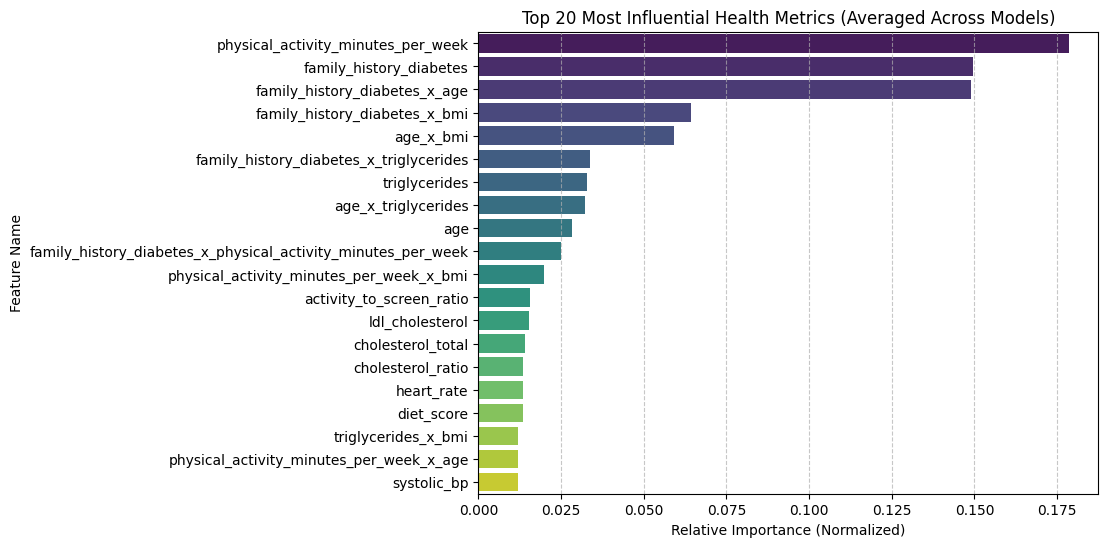

 Top 5 predictors of Diabetes in this dataset:
   3. physical_activity_minutes_per_week (0.1785)
   22. family_history_diabetes (0.1496)
   30. family_history_diabetes_x_age (0.1490)
   32. family_history_diabetes_x_bmi (0.0644)
   37. age_x_bmi (0.0592)


In [13]:
print_section_header("Feature importance analysis")
print_step("Aggregating importance from all models")

#Store feature importance
feat_imp_df = pd.DataFrame({"Feature": features})

feat_imp_df["XGBoost"] = models["XGBoost"].feature_importances_
feat_imp_df["LightGBM"] = models["LightGBM"].feature_importances_
feat_imp_df["CatBoost"] = models["CatBoost"].get_feature_importance()

#Normalize importances
for model in ["XGBoost", "LightGBM", "CatBoost"]:
    feat_imp_df[model] /= feat_imp_df[model].sum()

#Average importance across models
feat_imp_df["Average"] = feat_imp_df[["XGBoost", "LightGBM", "CatBoost"]].mean(axis=1)
feat_imp_df = feat_imp_df.sort_values("Average", ascending=False)

#Plot top features
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Average",
    y="Feature",
    data=feat_imp_df.head(20),
    palette="viridis"
)
plt.title("Top 20 Most Influential Health Metrics (Averaged Across Models)")
plt.xlabel("Relative Importance (Normalized)")
plt.ylabel("Feature Name")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#Print top 5 features
print_step("Top 5 predictors of Diabetes in this dataset:")
for idx, row in feat_imp_df.head(5).iterrows():
    print(f"   {idx+1}. {row['Feature']} ({row['Average']:.4f})")


 ==================== MODEL PERFORMANCE VISUALIZATION ==================== 
 Generating ROC Curves with Viridis palette


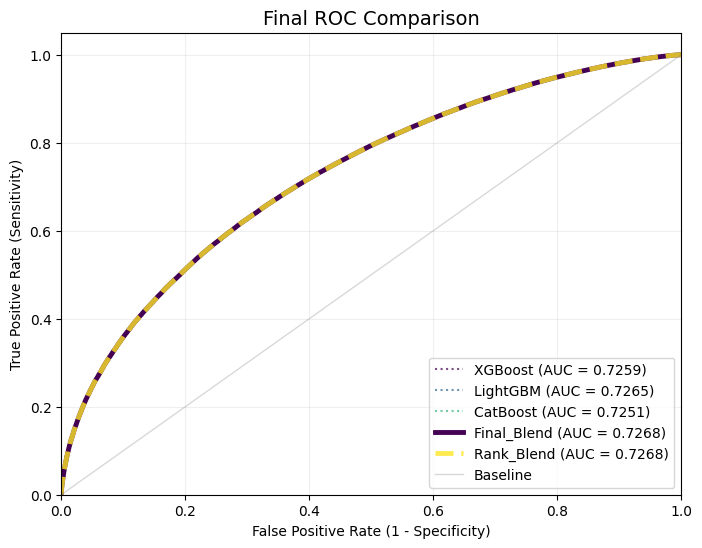

In [14]:
print_section_header("Model performance visualization")
print_step("Generating ROC Curves with Viridis palette")

plt.figure(figsize=(8, 6))

# Define color mapping
viridis_colors = [cm.viridis(i / 3) for i in range(4)]
colors = {
    'XGBoost': viridis_colors[0],
    'LightGBM': viridis_colors[1],
    'CatBoost': viridis_colors[2],
    'Final_Blend': '#440154', # Dark Purple
    'Rank_Blend': '#fde725'    # Bright Yellow
}

for col in oof_preds.columns:
    if col not in colors: continue
    
    fpr, tpr, _ = roc_curve(y, oof_preds[col])
    auc_val = roc_auc_score(y, oof_preds[col])
    
    # Define line styles
    if col == 'Final_Blend':
        lw, ls, alpha = 3.5, '-', 1.0
    elif col == 'Rank_Blend':
        lw, ls, alpha = 3.5, '--', 0.8
    else:
        lw, ls, alpha = 1.5, ':', 0.7
        
    plt.plot(fpr, tpr, label=f'{col} (AUC = {auc_val:.4f})', 
             lw=lw, linestyle=ls, color=colors[col], alpha=alpha)

# Reference line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='-', alpha=0.3, label='Baseline')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Final ROC Comparison', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

In [15]:
print_section_header("Final submission selection")

# Choose the best performing method from OOF scores
prob_score = roc_auc_score(y, oof_preds['Final_Blend'])
rank_score = roc_auc_score(y, oof_preds['Rank_Blend'])

if rank_score > prob_score:
    print_step(f"Rank Blending outperformed Probability Blending ({rank_score:.5f} vs {prob_score:.5f})")
    final_col = 'Rank_Blend'
else:
    print_step(f"Probability Blending remains superior ({prob_score:.5f} vs {rank_score:.5f})")
    final_col = 'Final_Blend'

submission = pd.DataFrame({
    ID_COL: test[ID_COL],
    TARGET: test_preds[final_col]
})

submission.to_csv('submission.csv', index=False)
print_success(f"Final submission saved using {final_col} method.")


 ==================== FINAL SUBMISSION SELECTION ==================== 
 Probability Blending remains superior (0.72679 vs 0.72678)
 Final submission saved using Final_Blend method.
